### Gathering Insights from airbnb city data for Seattle using Data science and Machine Learning



#### Get the required packages

In [7]:
#The anaconda environment used here comes with python 3.6 and all the necessary packages installed except for basemap which
#needs to be installed and scikit-learn which needs to be updated to v0.21

import os

#import functions module
from functions import *

#Data retrival and handling packages
import pandas as pd
import pandas_profiling
import numpy as np

#Data visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from mpl_toolkits.basemap import Basemap
import statsmodels.api as sm

#Get scikit learn tools for machine learning
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error

%matplotlib inline
sns.set(style='ticks')

#### Fetch airbnb city data from the local repository


In [8]:
#get calendar and listings data
calendar = get_airbnb_data('seattle', 'calendar')
listings = get_airbnb_data('seattle', 'listings')

calendar.sample(5)

,listing_id,date,available,price
625286,1594412,2016-02-14,t,$125.00
592743,3906076,2016-12-17,t,$110.00
876195,5047188,2016-07-17,t,$51.00
25138,7618605,2016-11-17,t,$175.00
1305543,5164194,2016-11-02,t,$95.00


In [9]:
listings.sample(5)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
2847,6436976,https://www.airbnb.com/rooms/6436976,20160104002432,2016-01-04,Spacious& clean apartment- Caphill!,This apartment is in a quaint area of capital ...,NaN,This apartment is in a quaint area of capital ...,none,NaN,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,2,3.51
886,9256702,https://www.airbnb.com/rooms/9256702,20160104002432,2016-01-04,Spacious loft apt centrally located,"Located in the heart of the city, on the edge ...",Loft apartment located in a 1905 house. The ap...,"Located in the heart of the city, on the edge ...",none,Please see this link for a detialed explanatio...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,1,1.80
1771,4597013,https://www.airbnb.com/rooms/4597013,20160104002432,2016-01-04,"Privacy, Stunning 180º Views, Close","Ten minutes to downtown, privacy, seclusion, N...",NaN,"Ten minutes to downtown, privacy, seclusion, N...",none,NaN,...,NaN,f,NaN,WASHINGTON,f,moderate,f,f,1,NaN
3037,1461971,https://www.airbnb.com/rooms/1461971,20160104002432,2016-01-04,Charming Natural Home in N. Seattle,"Stay in a quaint, natural home during your tim...","Comfortable, quaint home with lots of wood and...","Stay in a quaint, natural home during your tim...",none,Nice walkable neighborhood. Nearby shopping a...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.29
2934,9880665,https://www.airbnb.com/rooms/9880665,20160104002432,2016-01-04,Cozy Captiol Hill Nest Garden View,This spacious one bedroom is in a beautiful hi...,NaN,This spacious one bedroom is in a beautiful hi...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN


#### Format Calendar data 



In [10]:
#Convert date to pandas datetime format
calendar['date'] = to_date_time(calendar.date)

#Convert price to type float
calendar['price'] = to_numeric(calendar.price)

calendar.sample(5)

,listing_id,date,available,price
476312,8308386,2016-12-21,t,244.0
632319,5252543,2016-05-22,t,54.0
905743,8002965,2016-06-30,f,NaN
1195574,9679741,2016-07-21,f,NaN
515163,5058302,2016-05-31,t,195.0


#### Visualize pricing trends in relation to time of year

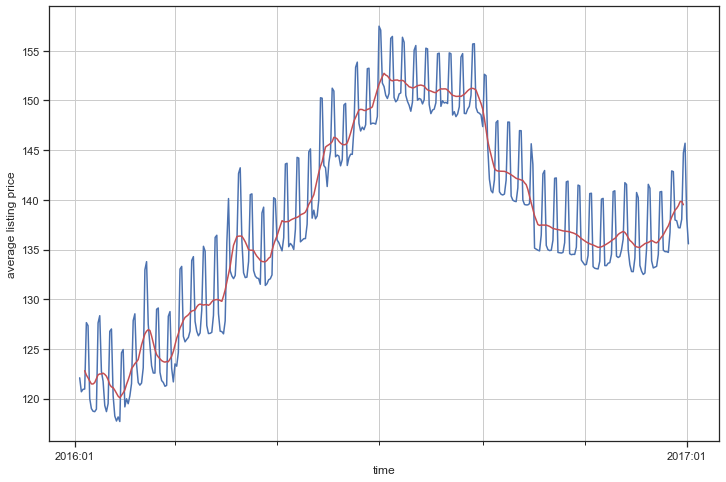

In [11]:
#for each date, calculate mean price over all available property listings
df = pd.DataFrame(calendar.groupby('date')['price'].mean())

#decompose observed time series into its 3 components: trend, seasonality and noise
decomposition = sm.tsa.seasonal_decompose(df, model='additive')    #price = Level + Trend + Seasonality + Noise

#plot oberved time series of property prices
plot_time_series(df.index, df.price)

#plot price trend
plt.plot(decomposition.trend.index, decomposition.trend, "-r")

plt.show()

#### Clean and format listings data

In [12]:
#Look at the features
pandas_profiling.ProfileReport(listings)

Number of variables,92
Number of observations,3818
Total Missing (%),8.5%
Total size in memory,2.7 MiB
Average record size in memory,736.0 B
Numeric,25
Categorical,51
Boolean,0
Date,0
Text (Unique),2
Rejected,14


In [15]:
num_cols = ['latitude','longitude','accommodates',
            'bathrooms', 'bedrooms', 'beds', 'price','number_of_reviews',
            'reviews_per_month', 'availability_365', 'guests_included']

cat_cols = ['host_response_time', 'host_is_superhost', 'host_identity_verified',
            'neighbourhood_group_cleansed', 'property_type', 'room_type',
            'instant_bookable', 'cancellation_policy', 'host_identity_verified']

listings = listings[num_cols+cat_cols]

#get pricing data from the calendar dataset
listings['price'] = calendar.groupby('listing_id', sort=False, as_index=False)['price'].mean().drop('listing_id', axis=1)

listings.head()

,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,number_of_reviews,reviews_per_month,availability_365,guests_included,host_response_time,host_is_superhost,host_identity_verified,neighbourhood_group_cleansed,property_type,room_type,instant_bookable,cancellation_policy,host_identity_verified
0,47.636289,-122.371025,4,1.0,1.0,1.0,85.000000,207,4.07,346,2,within a few hours,f,t,Queen Anne,Apartment,Entire home/apt,f,moderate,t
1,47.639123,-122.365666,4,1.0,1.0,1.0,170.931271,43,1.48,291,1,within an hour,t,t,Queen Anne,Apartment,Entire home/apt,f,strict,t
2,47.629724,-122.369483,11,4.5,5.0,7.0,1301.818182,20,1.15,220,10,within a few hours,f,t,Queen Anne,House,Entire home/apt,f,strict,t
3,47.638473,-122.369279,3,1.0,0.0,2.0,100.000000,0,NaN,143,1,NaN,f,t,Queen Anne,Apartment,Entire home/apt,f,flexible,t
4,47.632918,-122.372471,6,2.0,3.0,3.0,462.739726,38,0.89,365,6,within an hour,f,t,Queen Anne,House,Entire home/apt,f,strict,t


#### Visualize feature correlations

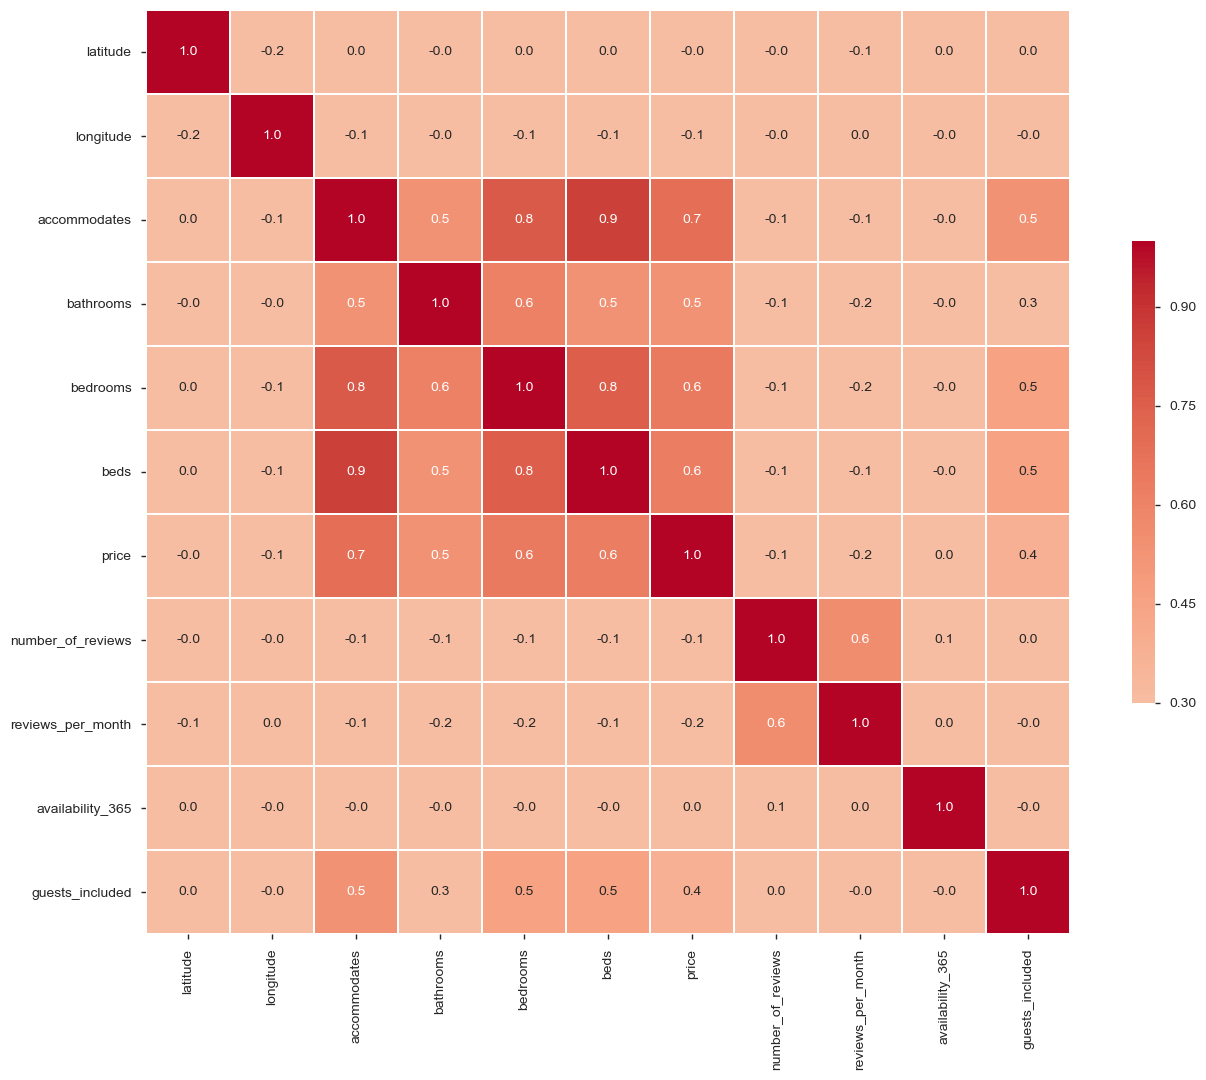

In [17]:
corr = listings.corr()
g = sns.heatmap(corr, vmin=0.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.1f', cmap='coolwarm')
sns.despine()

g.figure.set_size_inches(16,12)

plt.show()

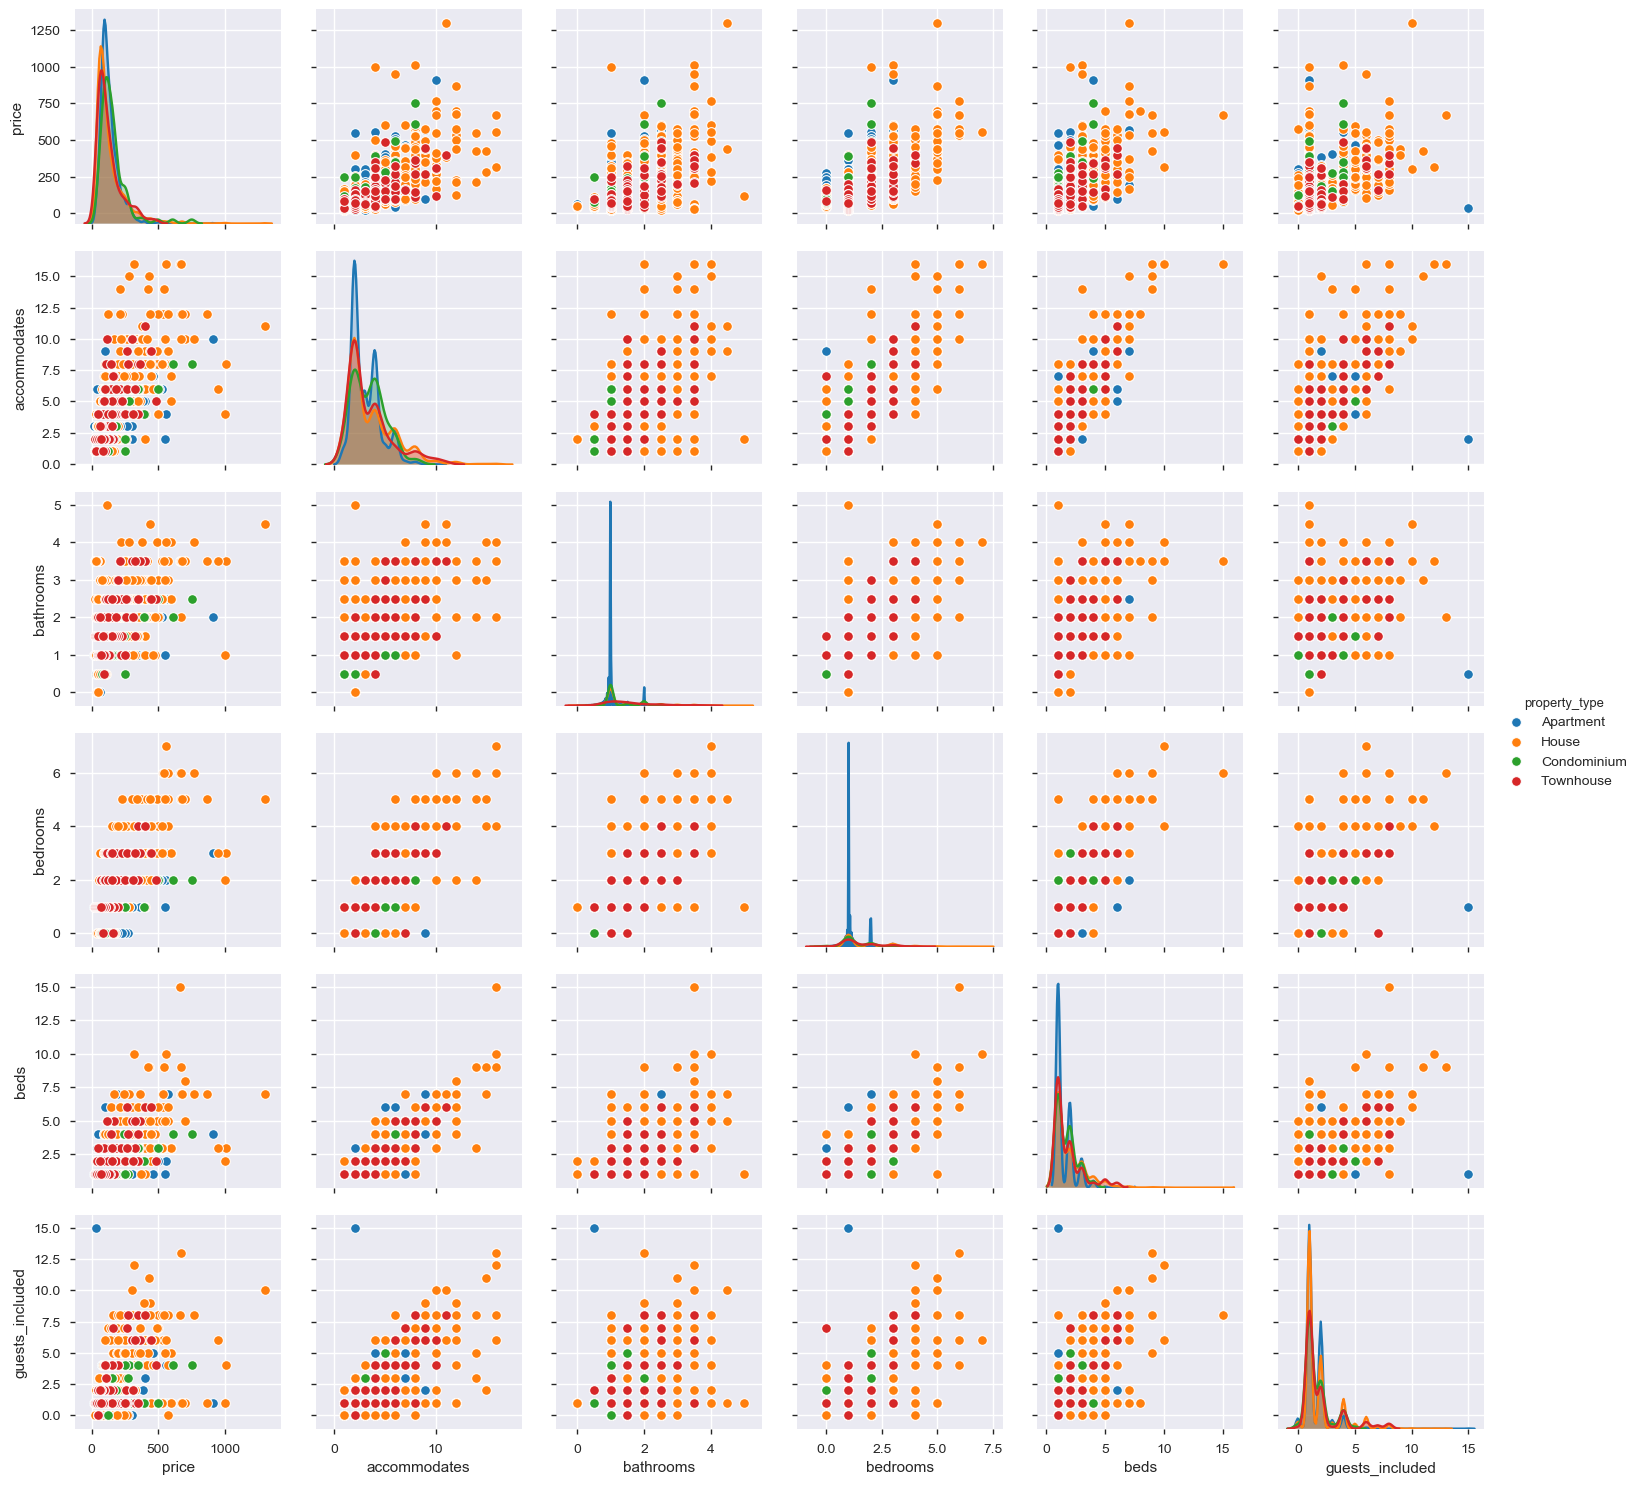

<Figure size 1200x1000 with 0 Axes>

In [19]:
filtered_listings = listings[listings['property_type'].isin(['House', 'Apartment', 'Condominium', 'Townhouse'])].copy()

g = sns.pairplot(filtered_listings[['price', 'accommodates', 'bathrooms',
                           'bedrooms', 'beds', 'guests_included', 'property_type']], hue='property_type')
sns.despine()
plt.figure(figsize=(12,10))
plt.show()

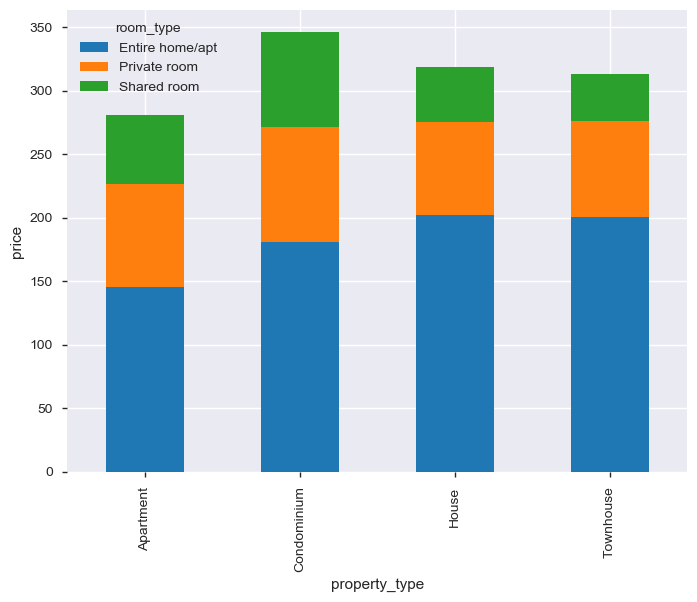

In [22]:
df = filtered_listings.groupby(['property_type', 'room_type'])['price'].mean().unstack()
df.plot.bar(stacked=True, figsize=(8,6))
plt.ylabel('price')
plt.show()

C:\Users\samee\Anaconda3\envs\machine_learning\lib\site-packages\seaborn\categorical.py:1324: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\Users\samee\Anaconda3\envs\machine_learning\lib\site-packages\seaborn\categorical.py:1328: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


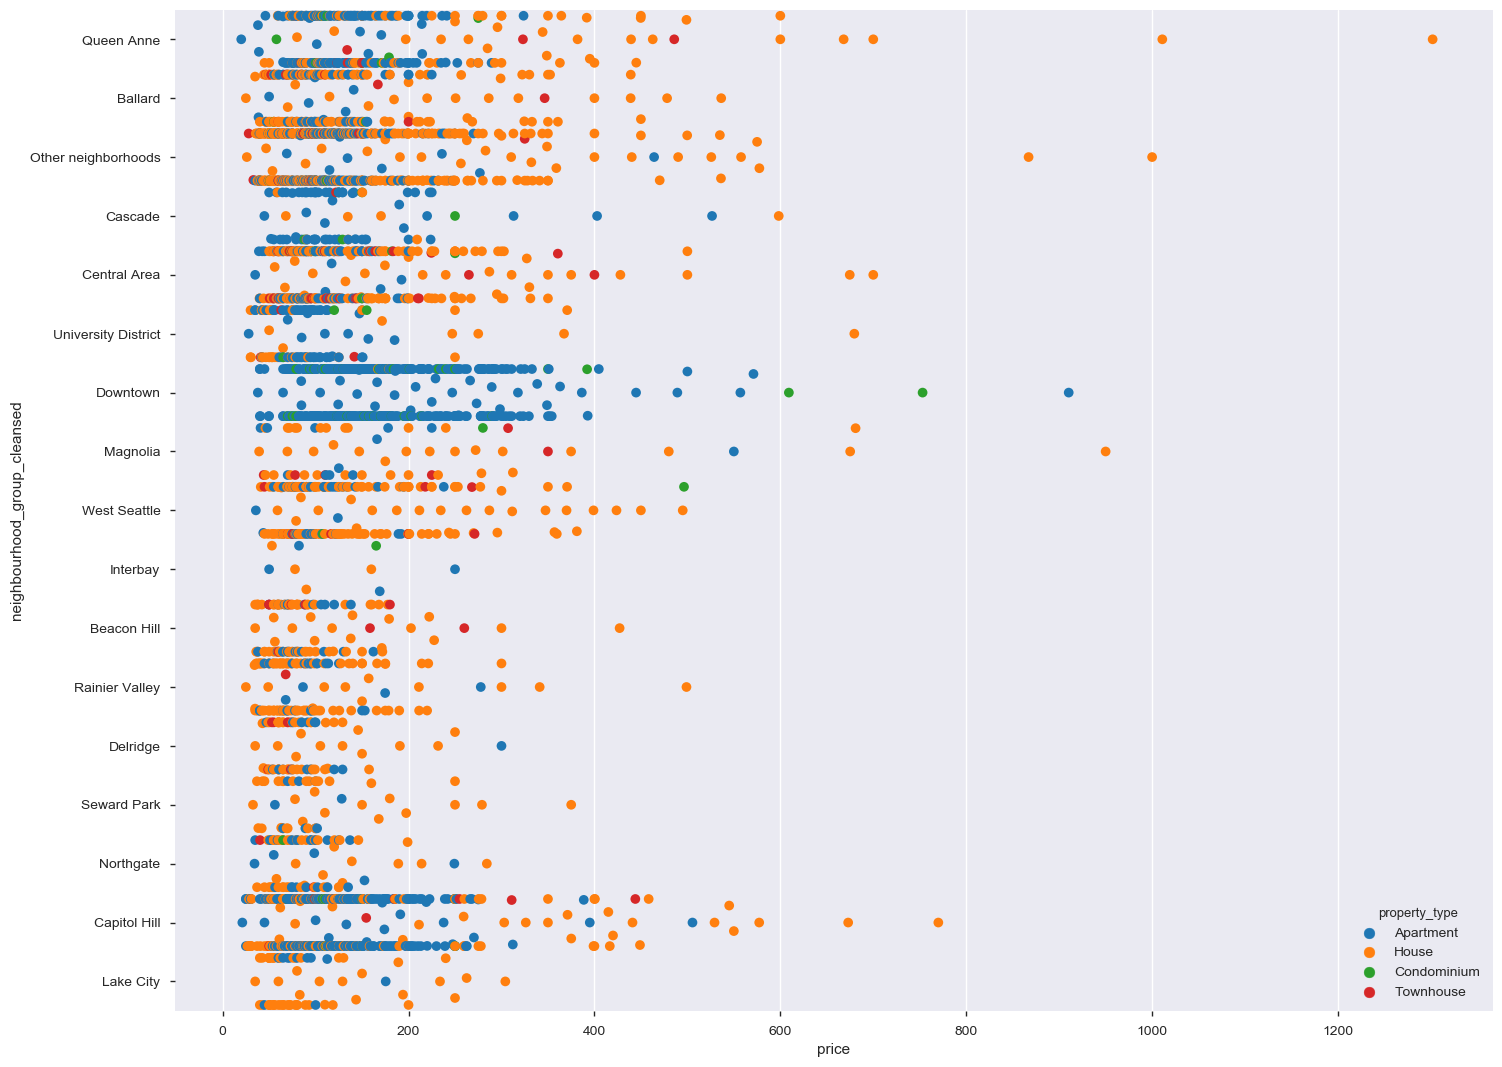

In [23]:
g = sns.swarmplot(y='neighbourhood_group_cleansed',
                 x='price',
                  hue='property_type',
                 data=filtered_listings,
                 size=7)
sns.despine()
g.figure.set_size_inches(17,13)
plt.show()

#### Visualize property price variation in relation to location


c:\code\Udacity\airbnb\functions.py:83: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  llcrnrlon=lon_0-0.05, urcrnrlon=lon_1+0.05)
c:\code\Udacity\airbnb\functions.py:87: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  m.drawcountries(linewidth=1)
c:\code\Udacity\airbnb\functions.py:88: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  m.drawcounties(color='red', linewidth=1)


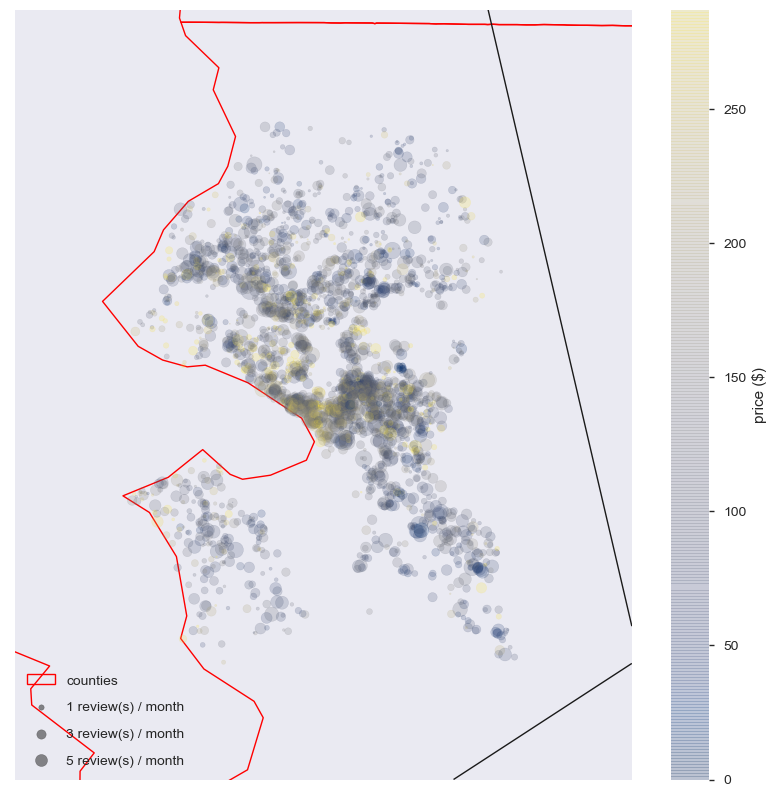

In [24]:
df = listings[['latitude', 'longitude', 'price', 'reviews_per_month']].copy()

#clean df 
df.dropna(axis=0, inplace=True)

latitudes = df.latitude
longitudes = df.longitude
price_distribution = df.price
activity_distribution = df.reviews_per_month

plot_geographical(latitudes, longitudes, price_distribution, activity_distribution)

#### Prepare data for machine learning pipelines


In [25]:
listings_ml = listings.dropna(subset=['price'], axis=0)

X = listings_ml.drop('price', axis=1)
y = listings_ml['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

upper_limit = y_train.quantile(0.99)
lower_limit = y_train.quantile(0.01)

is_over_limit = y_train > upper_limit
is_under_limit = y_train < lower_limit

y_train[is_over_limit] = upper_limit
y_train[is_under_limit] = lower_limit

In [34]:
num_cols = ['latitude','longitude','accommodates',
            'bathrooms', 'bedrooms', 'beds','number_of_reviews',
            'reviews_per_month', 'availability_365', 'guests_included']

cat_cols = ['host_response_time', 'host_is_superhost', 'host_identity_verified',
            'neighbourhood_group_cleansed', 'property_type', 'room_type',
            'instant_bookable', 'cancellation_policy', 'host_identity_verified']

cat_pipeline = Pipeline([
    ('si', SimpleImputer(strategy='constant', fill_value='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

num_pipeline = Pipeline([
    ('si', SimpleImputer(strategy='most_frequent')),
    ('ss', StandardScaler())
])

transformers = [('cat', cat_pipeline, cat_cols),
                ('num', num_pipeline, num_cols)]

ct = ColumnTransformer(transformers=transformers)


X_train_prepared = ct.fit_transform(X_train)
X_test_prepared = ct.transform(X_test)

lin_reg = LinearRegression()
svm_reg = SVR()
rnd_reg = RandomForestRegressor()

cv_scores = []
fit_score = []
for model in (lin_reg, svm_reg, rnd_reg):
    model.fit(X_train_prepared, y_train)
    cv_score = cross_val_score(model, X_train_prepared, y_train, cv=3, scoring='neg_mean_squared_error')
    cv_scores.append(np.sqrt(-cv_score.mean()))
    fit_score.append(model.score(X_train_prepared, y_train))
    
print('linear model - cv: ', cv_scores[0], ' fit: ', fit_score[0] )
print('support vector machine - cv: ', cv_scores[1], ' fit: ', fit_score[1])
print('random forrest regressor - cv: ', cv_scores[2], ' fit: ', fit_score[2])

C:\Users\samee\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\samee\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\samee\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\same

linear model - cv:  743566149751.5961  fit:  0.7006898249503604
support vector machine - cv:  68.94550187787068  fit:  0.45261745387410973
random forrest regressor - cv:  48.97490762221058  fit:  0.944823514138305


In [35]:
param_grid = [
    {'n_estimators': [80, 120, 160, 200], 'max_features': [0.1, 0.15, 0.20, 0.25], 'bootstrap':[True], 'n_jobs':[-1]},
  ]

grid_search_cv = GridSearchCV(RandomForestRegressor(), param_grid, cv=3, scoring='neg_mean_squared_error')

grid_search_cv.fit(X_train_prepared, y_train)
bst_estm = grid_search_cv.best_estimator_
y_pred = bst_estm.predict(X_test_prepared)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

59.490443227014886

In [47]:
features = np.concatenate((ct.named_transformers_['cat'].named_steps['ohe'].get_feature_names(),num_cols))
feature_importances = bst_estm.feature_importances_
importances = pd.DataFrame({'features':features, 'importances':feature_importances}).sort_values('importances', ascending=False).reset_index(drop=True).head(n=15)
importances.sample(15)

,features,importances
7,longitude,0.042354
12,x4_Downtown,0.018067
4,x6_Entire home/apt,0.055724
11,number_of_reviews,0.026185
1,accommodates,0.149313
13,x8_strict,0.014055
9,x6_Private room,0.036556
8,availability_365,0.042042
10,guests_included,0.035540
6,reviews_per_month,0.042705


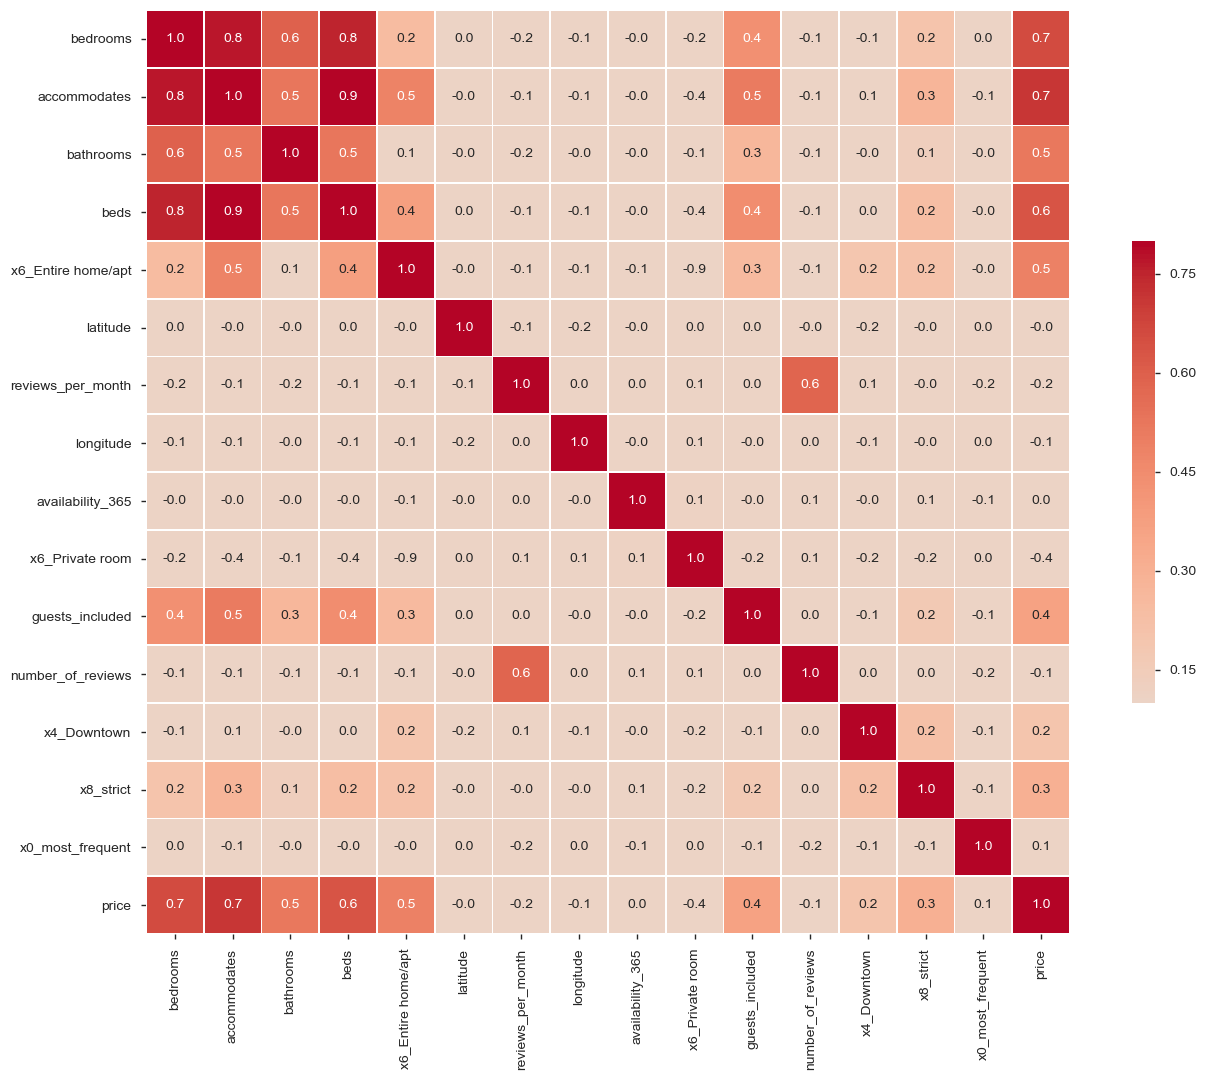

In [48]:
df = pd.DataFrame(X_train_prepared, columns=features)
df = df[importances.features[:15]]
df['price'] = y_train.values

corr = df.corr()

g = sns.heatmap(corr, vmin=0.1, vmax=0.8, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.1f', cmap='coolwarm')
sns.despine()

g.figure.set_size_inches(16,12)

plt.show()

In [45]:
y_train.values

array([ 61.76404494, 130.        ,  71.91620112, ..., 107.54794521,
       107.16292135, 243.93617021])